<a href="https://colab.research.google.com/github/MASHAR27/BCHACKS2024/blob/main/New_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget file.weasoft.com/trans2.seq

--2024-01-28 00:58:55--  http://file.weasoft.com/trans2.seq
Resolving file.weasoft.com (file.weasoft.com)... 149.28.13.194
Connecting to file.weasoft.com (file.weasoft.com)|149.28.13.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66819385 (64M)
Saving to: ‘trans2.seq.1’

trans2.seq.1        100%[===================>]  63.72M   222MB/s    in 0.3s    

2024-01-28 00:58:56 (222 MB/s) - ‘trans2.seq.1’ saved [66819385/66819385]



In [2]:
import torch
import numpy as np

# !pip install wandb
device = 'cuda' if torch.cuda.is_available() else 'cpu'

DIM = 512
import math
import torch.nn as nn
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)].to(device)
        return x
#https://pytorch.org/tutorials/beginner/transformer_tutorial.html

class Music(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.pos = PositionalEncoding(DIM, max_len=201)#torch.nn.Embedding(200, DIM).to(device)
    self.projection = torch.nn.Embedding(128, DIM).to(device)
    self.trans = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(DIM, 16, batch_first=True), 16).to(device)
    self.output = torch.nn.Linear(DIM, 128).to(device)
  def forward(self, x):
    #pos = self.pos(torch.arange(0,200).to(device))
    feature = self.projection(x)
    feature = self.pos(feature)
    feature = self.trans(feature, mask=torch.nn.Transformer.generate_square_subsequent_mask(200), is_causal=True)
    return self.output(feature)
model = Music()
model(torch.rand(1,200).to(torch.int32).to(device)).shape


torch.Size([1, 200, 128])

In [3]:
with open("trans2.seq","r") as f:
  data=[[int(j) for j in i.split(" ")[:200] if j!=""] for i in f.read().split("\n") if len(i.split(" "))>=200]

new_data = []
for i in data:
  if len(i)==200:
    new_data.append(i)


In [4]:
new_data = np.array(new_data)

In [5]:
new_data.shape

(83261, 200)

(array([2.852101e+06, 2.212200e+04, 1.920537e+06, 3.151930e+06,
        4.211507e+06, 3.706670e+06, 7.149480e+05, 6.774400e+04,
        4.117000e+03, 5.240000e+02]),
 array([  0. ,  12.7,  25.4,  38.1,  50.8,  63.5,  76.2,  88.9, 101.6,
        114.3, 127. ]),
 <BarContainer object of 10 artists>)

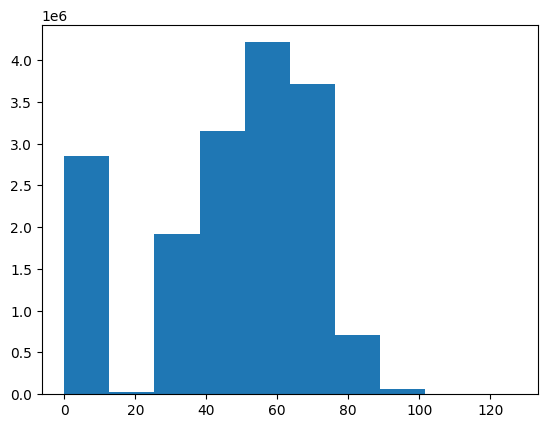

In [6]:

import pylab
pylab.hist((new_data).flatten())

In [7]:
!pip install wandb

In [8]:
import wandb
wandb.login()

run = wandb.init(
    project="ba-hacks",
)

wandb: Currently logged in as: wguo6358 (3dsmile). Use `wandb login --relogin` to force relogin


In [9]:
BATCH_SIZE = 16

import random
def getdata():
  data = random.choices(new_data, k=BATCH_SIZE)
  data = np.array(data)
  return np.concatenate((np.zeros((BATCH_SIZE,1)),data[:,:-1]), axis=1), data

np.concatenate((np.zeros((10,1)),new_data[:10,:-1]), axis=1).shape

(10, 200)

In [10]:
!pip install pip install focal_loss_torch

In [11]:
from focal_loss.focal_loss import FocalLoss

In [16]:
# c = FocalLoss(gamma=0.7)
# m = torch.nn.Softmax(dim=-1)
# def loss_fn(o, t):
#   return c(m(o),t)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.5)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler =  torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, len(new_data)//BATCH_SIZE*10)

In [ ]:
model = model.to(device)
runing_loss = 0
count = 0
for epoch in range(30):
  for i in range(len(new_data)//BATCH_SIZE):
    x, y = getdata()
    x, y = torch.tensor(x).to(device).to(torch.int32), torch.tensor(y).to(device).to(torch.int64)
    output = model(x)
    loss = loss_fn(output.permute(0,2,1), y)
    loss.backward()
    runing_loss += loss.item()
    count += 1
    if count==50:
      wandb.log({"loss":runing_loss/50})
      runing_loss = 0
      count = 0
    optimizer.step()
    scheduler.step()
torch.save(model, "music.mod")

In [ ]:
y.shape